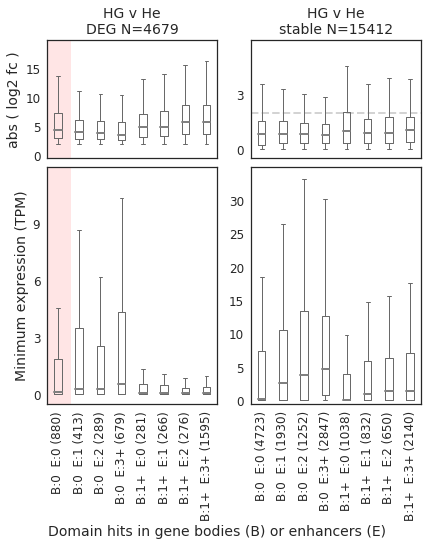

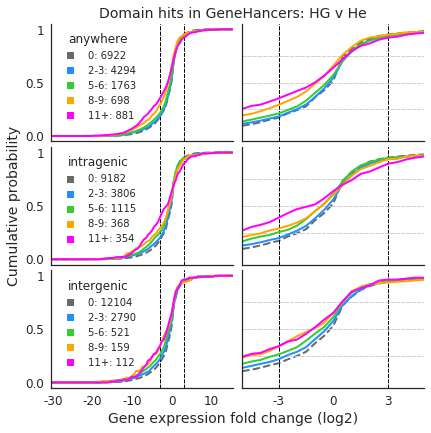

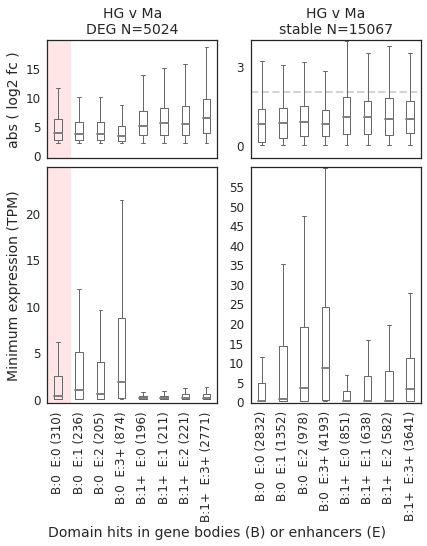

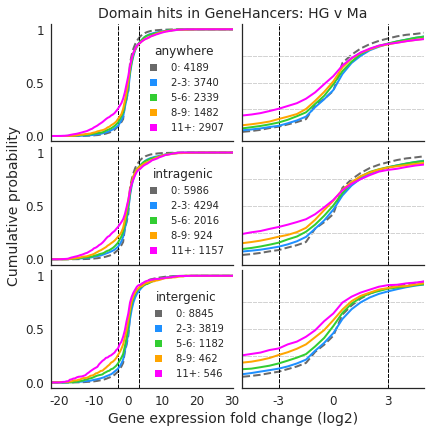

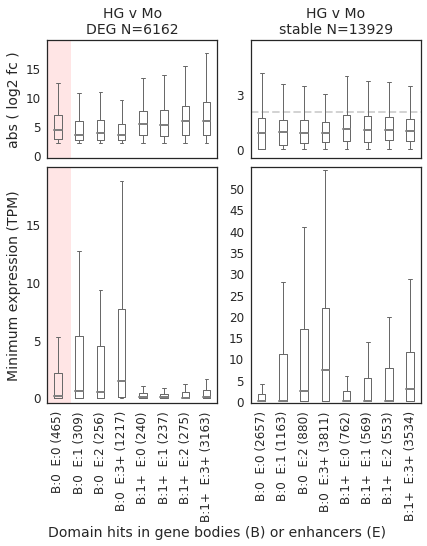

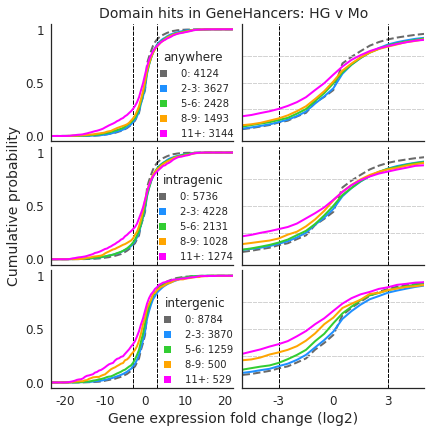

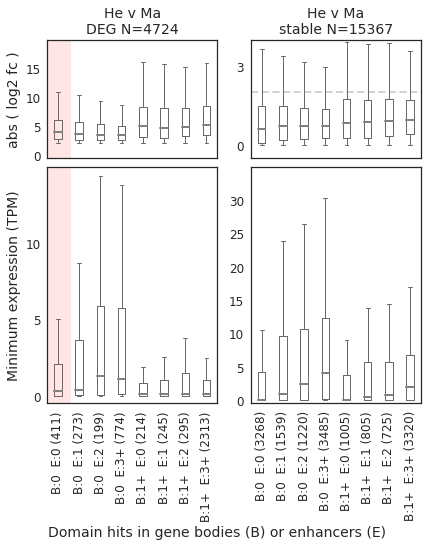

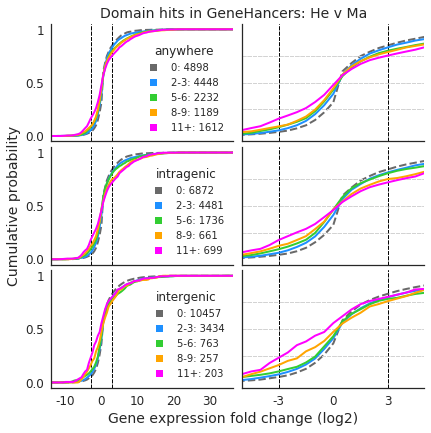

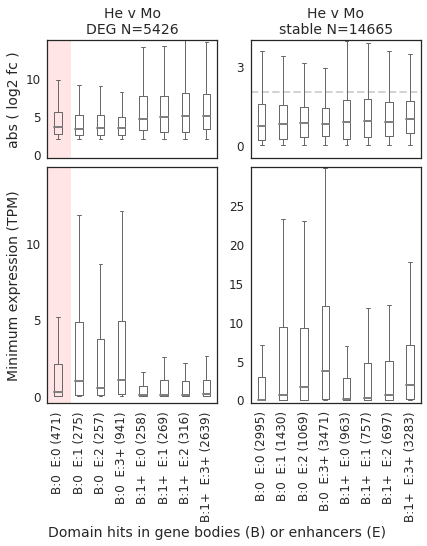

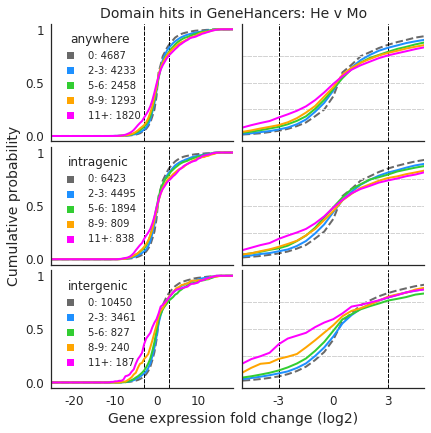

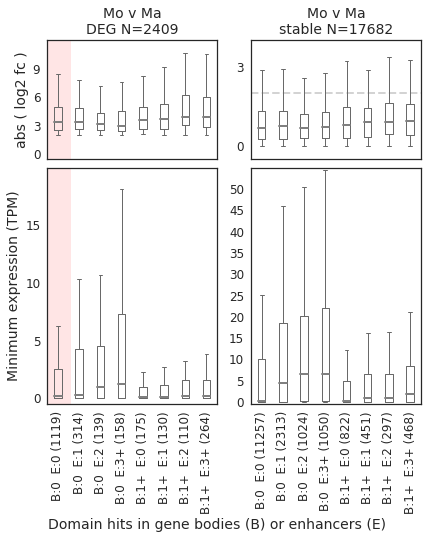

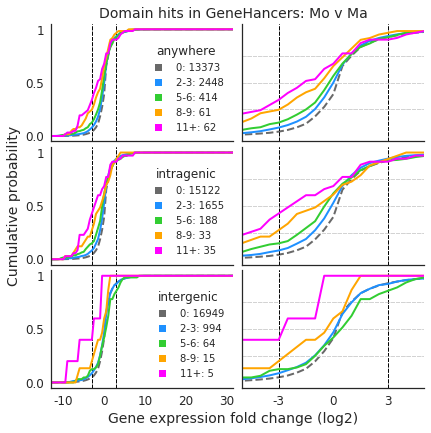

In [1]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import csv as csv
import json as js
import time as ti

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
import seaborn as sns

# What does this do?
# Plot boxplots of minimum TPM
# log2 fold-change for genes
# stratified by HSP hits
# (body/enhancer)

### THIS FILE IS NEEDED TO PREPARE
### THE CACHE DATA FOR OTHER PLOTS

date = '20180921'

run_plot_gene_enh_hsp = True
run_dump_genetrail_lists = False

save_figures = False

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

segmentations = ['cmm18', 'esc18', 'ecs10']
scorings = ['penem', 'ordem', 'penrep', 'ordrep']

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

isect_folder = os.path.join(fhgfs_base, 'bedtools/deep/isect_gene_hsp')

genetrail_out = os.path.join(fhgfs_base, 'genetrail/input_lists', date)

tpm_file = os.path.join(fhgfs_base, 'salmon', 'deep', 'agg_gene_tpm.h5')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'

fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
                   

def extract_table_header(fpath):
    hsp_header = ['chrom', 'start', 'end', 'name',
                  'nat_score', 'expect', 'pv',
                  'nat_score_lnorm', 'group1', 'group2']
    hsp_header = ['hsp_' + h for h in hsp_header]
    with open(fpath, 'r') as table:
        hd = table.readline().strip('#').strip().split('\t')
    header = hd + hsp_header + ['overlap']
    return header
    
    
def load_gene_ovl_table(fpath, hit_type, header):
    
    if header is None:
        header = extract_table_header(fpath)

    records = dict()
    with open(fpath, 'r', newline='') as table:
        _ = table.readline()
        reader = csv.DictReader(table, delimiter='\t',
                                fieldnames=header)
        for row in reader:
            try:
                gene = records[row['name']]
            except KeyError:
                gene = {'name': row['name'], 'symbol': row['symbol'],
                        'log2fc': row['log2fc'], 'is_de': row['is_de'],
                        'baseMean': row['baseMean'], hit_type: 0, 'padj': row['padj']}
                records[row['name']] = gene
            if int(row['overlap']) > 0:
                gene[hit_type] += 1
    df = pd.DataFrame.from_records(list(records.values()), index='name')
    df['log2fc'] = df['log2fc'].astype(np.float32)
    df['is_de'] = df['is_de'].astype(np.int8)
    df['padj'] = df['padj'].astype(np.float32)
    return df, header
    

def load_enhancer_ovl_table(fpath, header):
    
    if header is None:
        header = extract_table_header(fpath)
    
    records = dict()
    with open(fpath, 'r', newline='') as table:
        _ = table.readline()
        reader = csv.DictReader(table, delimiter='\t',
                                fieldnames=header)
        for row in reader:
            try:
                gene = records[row['name']]
            except KeyError:
                gene = {'name': row['name'], 'enhancer': set(),
                        'enh_hits': set()}
                records[row['name']] = gene
            gene['enhancer'].add((row['GHid'], int(row['intragenic'])))
            if int(row['overlap']) > 0:
                gene['enh_hits'].add((row['GHid'], int(row['intragenic'])))
                
    for k, v in records.items():
        v['total_enh'] = len(v['enhancer'])
        v['intra_enh'] = sum([t[1] for t in v['enhancer']])
        v['inter_enh'] = v['total_enh'] - v['intra_enh']
        v['total_hits'] = len(v['enh_hits'])
        v['intra_hits'] = len([t for t in v['enh_hits'] if t[1] == 1])
        v['inter_hits'] = v['total_hits'] - v['intra_hits']
        del v['enhancer']
        del v['enh_hits']
        
    df = pd.DataFrame.from_records(list(records.values()), index='name')
    return df, header
    
                
def load_expression_data(s1, s2, select_genes):
    
    with pd.HDFStore(tpm_file, 'r') as hdf:
        if s1 == 'Liver':
            data = pd.concat([hdf[k] for k in hdf.keys()], axis=1, ignore_index=False)
        else:
            load_keys = [k for k in hdf.keys() if k.endswith(s1) or k.endswith(s2)]
            assert len(load_keys) == 2, 'data missing'
            data = pd.concat([hdf[load_keys[0]], hdf[load_keys[1]]], axis=1, ignore_index=False)
        data['min_tpm'] = data.min(axis=1)
        data['max_tpm'] = data.max(axis=1)
        data['mean_tpm'] = data.mean(axis=1)
        data = data.loc[data.index.isin(select_genes), ['min_tpm', 'max_tpm', 'mean_tpm']].copy()
    return data
        

def get_partner_file(fpath, partner):
    
    if partner == 'promoter':
        partner_path = fpath.replace('/isect_gene_hsp/', '/isect_prom_hsp/')
        partner_path = partner_path.replace('gene_ovl_hsp', 'prom_ovl_hsp')
    elif partner == 'enhancer':
        partner_path = fpath.replace('/isect_gene_hsp/', '/isect_enh_hsp/')
        partner_path = partner_path.replace('gene_ovl_hsp', 'enh_ovl_hsp')
    else:
        raise ValueError('Unexpect partner file {}'.format(partner))
    return partner_path

    
def cache_overlap_data(rootfolder, cache_file):
    """
    """
    gene_header = None
    enh_header = None
    select_genes = None
    for gene_ovl in sorted(os.listdir(rootfolder)):
        if not gene_ovl.endswith('.tsv'):
            continue
        gene_ovl_path = os.path.join(rootfolder, gene_ovl)
        genes, gene_header = load_gene_ovl_table(gene_ovl_path, 'body_hit', gene_header)
        
        prom_ovl_path = get_partner_file(gene_ovl_path, 'promoter')
        proms, gene_header = load_gene_ovl_table(prom_ovl_path, 'prom_hit', gene_header)
        genes = genes.merge(proms.loc[:, ['prom_hit']].copy(), how='outer',
                            left_index=True, right_index=True)
        
        enh_ovl_path = get_partner_file(gene_ovl_path, 'enhancer')
        enh, enh_header = load_enhancer_ovl_table(enh_ovl_path, enh_header)
        genes = genes.merge(enh, how='outer', left_index=True, right_index=True)
        
        parts = gene_ovl.split('.')[0].split('_')
        seg, score = parts[3], parts[-1]
        c1, c2 = parts[4], parts[6]
        comp = c1 + '_vs_' + c2
        
        if select_genes is None:
            # select only genes on 1-22,X
            select_genes = set(genes.index)

        tpm_data = load_expression_data(c1, c2, select_genes)
        
        genes = genes.merge(tpm_data, how='outer', left_index=True, right_index=True)
        
        # genes w/o annotated enhancers have N/A after merge
        genes.fillna(0, inplace=True)
        
        assert genes.shape[0] == 20091, 'Genes missing for {}: {}'.format(gene_ovl, genes.shape[0])
               
        store_path = os.path.join(seg, score, comp)
        with pd.HDFStore(cache_file, 'a') as hdf:
            hdf.put(store_path, genes, format='fixed')
            
    return cache_file
    
    
def prepare_plot_data(data, data_type):
    
    boxes = []
    box_labels = []
    # genes w/o body hit and no enhancer hit
    select = np.logical_and(data['body_hit'] == 0, data['total_hits'] == 0)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:0  E:0 ({})'.format(sub.size))
    
    # genes w/o body hit AND at least 1 enhancer hit
    select = np.logical_and(data['body_hit'] == 0, data['total_hits'] == 1)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:0  E:1 ({})'.format(sub.size))
    
    select = np.logical_and(data['body_hit'] == 0, data['total_hits'] == 2)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:0  E:2 ({})'.format(sub.size))
    
    select = np.logical_and(data['body_hit'] == 0, data['total_hits'] >= 3)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:0  E:3+ ({})'.format(sub.size))
    
    # genes with at least one body hit
    select = np.logical_and(data['body_hit'] > 0, data['total_hits'] == 0)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:1+  E:0 ({})'.format(sub.size))
    
    # genes with at least one body hit
    select = np.logical_and(data['body_hit'] > 0, data['total_hits'] == 1)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:1+  E:1 ({})'.format(sub.size))
    
    # genes with at least one body hit
    select = np.logical_and(data['body_hit'] > 0, data['total_hits'] == 2)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:1+  E:2 ({})'.format(sub.size))
    
    # genes with at least one body hit
    select = np.logical_and(data['body_hit'] > 0, data['total_hits'] >= 3)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:1+  E:3+ ({})'.format(sub.size))
    
    return boxes, box_labels
    
    
def generate_bins(dataset, stepsize):
    """
    """
    fc_min = dataset['log2fc'].min()
    assert fc_min < 0, 'That is unexpected...'
    fc_lower = (fc_min // stepsize) * stepsize - stepsize
    fc_max = dataset['log2fc'].max()
    fc_upper = (fc_max // stepsize) * stepsize + stepsize
    bins = np.arange(fc_lower, fc_upper + 0.1, stepsize)
    bin_num = [i for i, b in enumerate(bins, start=1)]
    return bins, bin_num
    

def compute_densities(dataset, bins, hit_type):
    
    histograms = []
    labels = []
    lo_bounds = [0, 2, 5, 8, 11]
    hi_bounds = [0, 3, 6, 9, 1000]
    # no overlap
    for lo, hi in zip(lo_bounds, hi_bounds):
        select = np.logical_and(dataset[hit_type] >= lo, dataset[hit_type] <= hi)
        group = dataset.loc[select, 'log2fc']
        if group.size == 0:
            hist = np.zeros_like(histograms[0])
            histograms.append(hist)
        else:
            hist, bin_edges = np.histogram(group, bins, density=True)
            histograms.append(np.concatenate([[0], hist]))
        if lo == 0:
            labels.append('0: {}'.format(group.size))
        elif lo == max(lo_bounds):
            labels.append('{}+: {}'.format(lo, group.size))
        else:
            labels.append('{}-{}: {}'.format(lo, hi, group.size))
    
    return histograms, labels
    
    
    
def create_cdf_plot(datapoints, comp, fkey):
    
    fig, axes = plt.subplots(figsize=fig_sizes['two_col']['square'],
                             nrows=3, ncols=2,
                             sharex=False, sharey=False)
    stepsize = 0.5
    bins, bin_nums = generate_bins(datapoints, stepsize)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    data_colors = ['dimgrey', 'dodgerblue', 'limegreen', 'orange', 'magenta']
    
    # for all enhancers
    total_hist, total_labels = compute_densities(datapoints, bins, 'total_hits')
    # for intragenic
    intra_hist, intra_labels = compute_densities(datapoints, bins, 'intra_hits')
    # for intragenic
    inter_hist, inter_labels = compute_densities(datapoints, bins, 'inter_hits')
    row_title = {0: 'anywhere', 1: 'intragenic', 2: 'intergenic'}
    
    s1, s2 = comp.split('_vs_')
    for row_idx, (data, lab) in enumerate([(total_hist, total_labels),
                                           (intra_hist, intra_labels),
                                           (inter_hist, inter_labels)]):
        ax = axes[row_idx, 0]
        if row_idx == 0:
            tt = ax.set_title('Domain hits in GeneHancers: {} v {}'.format(s1, s2), fontsize=14)
            tt.set_position((1, 1))
        
        leg_handles = []
        for c, hist, l in zip(data_colors, data, lab):
            if c == 'dimgrey':
                style = 'dashed'
                zorder = 0
            else:
                style = 'solid'
                zorder = 2
            assert np.isclose(hist.sum() * stepsize, 1., atol=1e-6), 'CDF not 1'
            ax.plot(bins, np.cumsum(hist) * stepsize,
                    lw=2, ls=style, c=c, zorder=zorder,
                    label=l)
#             ax.axhline(0.75, 0, 1, c='lightgrey',
#                        ls='dashed', zorder=0, lw=1)
#             ax.axhline(0.5, 0, 1, c='lightgrey',
#                        ls='dashed', zorder=0, lw=1)
#             ax.axhline(0.25, 0, 1, c='lightgrey',
#                        ls='dashed', zorder=0, lw=1)
            
            ax.axvline(-3, 0, 1, c='black', alpha=0.5,
                       ls='dashed', zorder=0, lw=1)
            ax.axvline(3, 0, 1, c='black', alpha=0.5,
                       ls='dashed', zorder=0, lw=1)
            leg_patch = mlines.Line2D([], [], marker='s', markersize=7,
                                      lw=0, color=c, label=l)
            leg_handles.append(leg_patch)
        
        if comp == 'HG_vs_Mo':
            ax_leg = ax.legend(loc='right', handles=leg_handles,
                               fontsize=10, bbox_to_anchor=(1.05, 0.4))
        else:
            ax_leg = ax.legend(loc='best', handles=leg_handles,
                               fontsize=10)
        tt = ax_leg.set_title(row_title[row_idx], prop={'size': 12})
        
        if row_idx == 1:
            ax.set_ylabel('Cumulative probability', fontsize=14)
                
        if row_idx == 2:
            neg_ticks = np.arange(0, bins.min(), -10)[::-1]
            pos_ticks = np.arange(0, bins.max(), 10)

            x_ticks = np.concatenate([neg_ticks, pos_ticks[1:]])
            x_ticks = x_ticks.astype(np.int8)
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(map(str, x_ticks), fontsize=12)
            tt = ax.set_xlabel('Gene expression fold change (log2)', fontsize=14)
            tt.set_position((1, 0))
        else:
            ax.set_xticks([])
            
        ax.set_xlim(bins.min(), bins.max())

        y_ticks = [0., 0.5, 1]
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(map(str, y_ticks), fontsize=12)
        ax.set_ylim(-0.05, 1.05)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

            
        ax = axes[row_idx, 1]
        
        for c, hist in zip(data_colors, data):
            if c == 'dimgrey':
                style = 'dashed'
                zorder = 0
            else:
                style = 'solid'
                zorder = 2
            assert np.isclose(hist.sum() * stepsize, 1., atol=1e-6), 'CDF not 1'
            ax.plot(bins, np.cumsum(hist) * stepsize,
                    lw=2, ls=style, c=c, zorder=zorder)
            ax.axhline(0.75, 0, 1, c='lightgrey',
                       ls='dashed', zorder=0, lw=1)
            ax.axhline(0.5, 0, 1, c='lightgrey',
                       ls='dashed', zorder=0, lw=1)
            ax.axhline(0.25, 0, 1, c='lightgrey',
                       ls='dashed', zorder=0, lw=1)
            
            ax.axvline(-3, 0, 1, c='black', alpha=0.5,
                       ls='dashed', zorder=0, lw=1)
            ax.axvline(3, 0, 1, c='black', alpha=0.5,
                       ls='dashed', zorder=0, lw=1)
            
        ax.set_yticks([])
        if row_idx == 2:
            x_ticks = [-3, 0, 3]
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(map(str, x_ticks), fontsize=12)
        else:
            ax.set_xticks([])
        
        ax.set_xlim(-5, 5)
        #ax.set_ylim(-0.05, 1.05)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    return fig, []
    
    
def create_boxplot(datapoints, comp, fkey):
    """
    """
    boxcolor = 'dimgrey'
    medcolor = 'grey'
    median_props = {'color': medcolor, 'linewidth': 2}
    box_props = {'color': boxcolor, 'linewidth': 1}
    whisker_props = {'color': boxcolor, 'linewidth': 1}
    cap_props = {'color': boxcolor, 'linewidth': 1}
        
    
    fig, axes = plt.subplots(figsize=fig_sizes['two_col']['square'],
                             nrows=2, ncols=2, sharex=False, sharey=False,
                             gridspec_kw={'height_ratios': [1, 2]})
    data_lut = {(0, 0): ('diff', 'log2fc'), (0, 1): ('stable', 'log2fc'),
                (1, 0): ('diff', 'min_tpm'), (1, 1): ('stable', 'min_tpm')}
        
    plt.subplots_adjust(hspace=0.05, wspace=0.2)
    s1, s2 = comp.split('_vs_')
    for row in range(2):
        for col in range(2):
            ax = axes[row, col]
            gene_type, data_type = data_lut[(row, col)]
            
            if gene_type == 'diff':
                subset = datapoints.loc[datapoints['is_de'] == 1, :].copy()
            else:
                subset = datapoints.loc[datapoints['is_de'] < 1, :].copy()
            
            if row == 0 and col == 0:
                ax.set_title('{} v {}\nDEG N={}'.format(s1, s2, subset.shape[0]),
                             fontsize=14)
                ax.set_ylabel('abs ( log2 fc )', fontsize=14)
            elif row == 0 and col == 1:
                ax.set_title('{} v {}\nstable N={}'.format(s1, s2, subset.shape[0]),
                             fontsize=14)
                ax.axhline(2, 0, 1, lw=2, ls='dashed',
                           color='lightgrey', zorder=0)
            else:
                pass
            
            if row == 1 and col == 0:
                ax.set_ylabel('Minimum expression (TPM)', fontsize=14)
                xl_pos = ax.set_xlabel('Domain hits in gene bodies (B) or enhancers (E)', fontsize=14)
                xl_pos.set_position((1, 0))
                                    
            boxes, boxlabels = prepare_plot_data(subset, data_type)
                        
            ax.set_xlim(0, len(boxes) + 1)
                       
            bb = ax.boxplot(boxes, sym="", labels=None, widths=0.35,
                            medianprops=median_props, boxprops=box_props,
                            whiskerprops=whisker_props, capprops=cap_props)
            max_y = 0
            for cap in bb['caps']:
                max_y = max(max_y, cap.get_ydata()[0])
            if max_y < 12:
                ax.set_ylim(-0.5, max_y // 2 * 2 + 2)
                yticks = np.arange(0, np.ceil(max_y), 3, dtype=np.int8)
            else:
                ax.set_ylim(-0.5, max_y // 5 * 5 + 5)
                yticks = np.arange(0, np.ceil(max_y), 5, dtype=np.int8)
            
            ax.set_yticks(yticks)
            ax.set_yticklabels(map(str, yticks), fontsize=12)
            
            if row == 0:
                ax.set_xticks([])
            if row == 1:
                ax.set_xticklabels(boxlabels, fontsize=12, rotation=90)
            if col == 0:
                ax.axvline(1, 0, 1, lw=25, ls='solid', color='red',
                           alpha=0.1, zorder=0)
            
    return fig, []


def print_mirna_info(genes, mirna, cell):
    
    print('Cell ', cell)
    select = np.logical_and(mirna['name'].isin(genes.index),
                            mirna['celltype'] == cell)
    sub = mirna.loc[select, ['norm_count', 'mirna_id']]
    print('Unique miRNAs ', sub['mirna_id'].unique().size)
    dist = np.percentile(sub['norm_count'], [25, 50, 75, 95, 99])
    print('Count distribution ', dist)
    return


def dump_genetrail_lists():
    cache_file = os.path.join(cache_dir, '{}_plot_gene-enh-hsp_tpm-bin.h5'.format(date))
    if not os.path.isfile(cache_file):
        raise RuntimeError('No cache file detected')
    dump_folder = genetrail_out + '_miRNA'
    os.makedirs(dump_folder, exist_ok=True)
        
    mirna_cache = os.path.join(fhgfs_base, 'caching', 'notebooks', '20180711_mirna_exp_targets.h5')
        
    with pd.HDFStore(cache_file, 'r') as hdf:
        cached_keys = list(hdf.keys())
        for seg in segmentations:
            if seg != 'cmm18':
                continue
            for scoring in scorings:
                if scoring != 'emission':
                    continue
                load_keys = [k for k in cached_keys if seg in k and scoring in k]
                
                for k in load_keys:
                    comp = k.split('/')[-1]
                    if comp not in ['Ma_vs_Mo']:
                        continue
                    s1, s2 = comp.split('_vs_')
                    print('Dumping GeneTrail lists for {}'.format(comp))
                    data = hdf[k]
                    print('Loading miRNA')
                    with pd.HDFStore(mirna_cache, 'r') as cache:
                        mirna = cache['mirna_exp/' + comp]
                    print('miRNA loaded')
                    
                    
                    base_file = '_'.join([seg, scoring, comp, '{}']) + '.tsv'
                    deg = data.loc[data['genetype'] == 'diff', :].copy()
                    
                    select_miss = np.logical_and(deg['body_hsp'] == 0,
                                                 deg['total_hits'] == 0)
                    miss = deg.loc[select_miss, :]
                    miss_file = os.path.join(dump_folder, base_file.format('deg-miss'))
                    with open(miss_file, 'w') as dump:
                        _ = dump.write('\n'.join(miss.index.tolist()) + '\n')
                    
                    select_hit = np.logical_or(deg['body_hsp'] > 0,
                                               deg['total_hits'] > 0)
                    hit = deg.loc[select_hit, :]                    
                    hit_file = os.path.join(dump_folder, base_file.format('deg-hit'))
                    with open(hit_file, 'w') as dump:
                        _ = dump.write('\n'.join(hit.index.tolist()) + '\n')
                        
                    bmiss = deg.loc[deg['body_hsp'] == 0, :]
                    bmiss_file = os.path.join(dump_folder, base_file.format('deg-body-miss'))
                    with open(bmiss_file, 'w') as dump:
                        _ = dump.write('\n'.join(bmiss.index.tolist()) + '\n')
                    
                    print('=============================')
                    print('DEG - body miss')
                    print_mirna_info(bmiss, mirna, s1)
                    print_mirna_info(bmiss, mirna, s2)
                    
                    bhit = deg.loc[deg['body_hsp'] > 0, :]
                    bhit_file = os.path.join(dump_folder, base_file.format('deg-body-hit'))
                    with open(bhit_file, 'w') as dump:
                        _ = dump.write('\n'.join(bhit.index.tolist()) + '\n')
                    
                    print('=============================')
                    print('DEG - body hit')
                    print_mirna_info(bhit, mirna, s1)
                    print_mirna_info(bhit, mirna, s2)
                        
                    stg = data.loc[data['genetype'] == 'stable', :].copy()
                    stg_file = os.path.join(dump_folder, base_file.format('seg-any'))
                    with open(stg_file, 'w') as dump:
                        _ = dump.write('\n'.join(stg.index.tolist()) + '\n')
                        
                    stgmiss = stg.loc[stg['body_hsp'] == 0, :]
                    stgmiss_file = os.path.join(dump_folder, base_file.format('seg-body-miss'))
                    with open(stgmiss_file, 'w') as dump:
                        _ = dump.write('\n'.join(stgmiss.index.tolist()) + '\n')
                        
                    print('=============================')
                    print('SEG - body miss')
                    print_mirna_info(stgmiss, mirna, s1)
                    print_mirna_info(stgmiss, mirna, s2)
                                            
    return


def plot_gene_enh_hsp_ovl():
    cache_file = os.path.join(cache_dir, '{}_plot_gene-enh-hsp_tpm-bin.h5'.format(date))
    #os.unlink(cache_file)
    if not os.path.isfile(cache_file):
        _ = cache_overlap_data(isect_folder, cache_file)
    elif os.stat(cache_file).st_size < 10e2:
        _ = cache_overlap_data(isect_folder, cache_file)
    else:
        print('Assuming cache file is valid')
    
    with pd.HDFStore(cache_file, 'r') as hdf:
        cached_keys = list(hdf.keys())
        
        for seg in segmentations:
            if seg != 'cmm18':
                continue
            for scoring in scorings:
                if scoring != 'penem':
                    continue
                load_keys = [k for k in cached_keys if seg in k and scoring in k]
                
                for k in load_keys:
                    comp = k.split('/')[-1]
                    if comp == 'Liver_vs_Blood':
                        continue
                    data = hdf[k]               

                    if seg == 'ecs18':
                        fk = 'SX'
                        subfolder = fig_supp
                    else:
                        fk = 'SX'
                        subfolder = fig_supp

                    fig, exart = create_boxplot(data, comp, fk)                    
                    if save_figures:
                        outname = 'fig_{}_gene-enh-hsp_tpm-box_{}_{}_{}'.format(fk, seg, scoring, comp)
                        
                        out_pdf = os.path.join(subfolder, outname + '.pdf')
                        fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                        out_png = os.path.join(subfolder, outname + '.png')
                        fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
                        
                    fig, exart = create_cdf_plot(data, comp, fk)                    
                    if save_figures:
                        outname = 'fig_{}_gene-enh-hsp_tpm-cdf_{}_{}_{}'.format(fk, seg, scoring, comp)
                        
                        out_pdf = os.path.join(subfolder, outname + '.pdf')
                        fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                        out_png = os.path.join(subfolder, outname + '.png')
                        fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
    return 0



    
if run_plot_gene_enh_hsp:
    plot_gene_enh_hsp_ovl()

if run_dump_genetrail_lists:
    dump_genetrail_lists()
    
    